# Eliminación de valores faltantes: Pairwise y Listwise

Hasta el momento hemos estado analizando toda una posibilidad de valores faltantes; encontrándolos en distintas formas  y codificaciones, también logramos encontrar valores faltantes en los que ni siquiera nos imaginábamos que faltaban .

Ahora vamos a trabajar para tratar adecuadamente los valores faltantes:
- **Eliminación** Se refiere a que añadimos valores o identificar un valor para los faltantes. Es decir para que sigan en los registros pero con un valor añadido.
- **Imputación**

<div class="alert alert-warning", role="alert">
    <b style="font-size: 1.5em;">🚧 Advertencia</b>
    <br>
    <br>
    <p>
    La eliminación de valores faltantes <b>asume</b> que los valores faltantes están perdidos
    completamente al azar (<code>MCAR</code>). En cualquier otro caso, realizar una
    eliminación de valores faltantes podrá ocasionar <b>sesgos</b> en los
    análisis y modelos subsecuentes.
    </p>
</div>

#### Importando librerías

In [1]:
### Importando librerías
import janitor      #Crear pipelines de limpieza de datos
import matplotlib.pyplot as plt
import missingno    #Visualizar valores faltantes 
import numpy as np
import pandas as pd
import pyreadr      #Leer archivos adr para este curso
import seaborn as sns
import session_info
import upsetplot    #Para gráfica de relaciones 
                    #de nuestros valores faltantes

#### Configurar el aspecto general de las gráficas del proyecto

In [2]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (10, 10)
    }
)

sns.set_style("whitegrid")

#### Leer conjunto de datos

In [3]:
#Cargar conjunto de datos
riskfactors = pyreadr.read_r('dataset/riskfactors.rda')

#Convertirlo a Data Frame
riskfactors_df = next(iter(riskfactors.values()))

#Borrar el diccionario
del riskfactors

In [4]:
#Verificar tipo 
#type(riskfactors_df)

#LLamar al data frame
riskfactors_df.head()

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100,smoke_days,smoke_stop,smoke_last,diet_fruit,diet_salad,diet_potato,diet_carrot,diet_vegetable,diet_juice
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,No,NaN,NaN,NaN,1095,261,104,156,521,12
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,No,NaN,NaN,NaN,52,209,52,0,52,0
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,No,NaN,NaN,NaN,36,156,52,24,24,24
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Yes,Everyday,Yes,NaN,-7,261,209,261,365,104


## Eliminación

In [5]:
#ver el tamaño de nuestro dataset
riskfactors_df.shape

(245, 34)

Vemos el tamaño de nuestro data set

### Pairwaise deletion (Eliminación por pares)
Solo se eliminarán los valores faltantes durante los cálculos de ciertas funciones. 

Por ejemplo:
- Suma.
- Conteo.

Es decir siguen ahí pero se ignoran

**¿Cómo podemos ejecutarlo?**

In [8]:
(
    riskfactors_df
    .weight_lbs
    .isna()
    .sum()
)

10

Tenemos **10** valores nulos, todo bien hasta ahí y ejecutaremos un cálculo.

In [9]:
(
    riskfactors_df
    .weight_lbs
    .mean()
)

174.26808510638298

Observemos a detalle.

In [11]:
#tamaño de la columna
riskfactors_df.weight_lbs.size

245

**¿Cómo funciona el promedio?**     
A través de contar, entonces veamos

In [12]:
#valores disponibles (reales) - [ignorando faltantes]
riskfactors_df.weight_lbs.count()

235

Entonces como se puede ver **Pandas** está haciendo una eliminación por **Pairwise**.

Entonces esta ignorando a nuestros valores faltantes en cada operación, esto es lo que hace **Pandas** en cada función:
- media
- suma
- desviación estándar
- Cualquier función que calcula un estadístico

Si tenemos valores faltantes **Pandas** los va a ignorar. Esto tiene un beneficio porque no necesitas de una operación extra.

Por otro lado no es un beneficio cuando nosotros tenemos **demasiados** valores faltantes y así podríamos meter algún **sesgo** en nuestros valores faltantes.

In [14]:
riskfactors_df.weight_lbs.sum()/riskfactors_df.weight_lbs.count()

174.26808510638298

#### ¿Cómo evitar el comportamiento de Pandas ( Pairwise)?

In [18]:
riskfactors_df.mean(skipna=False)

TypeError: 'Categorical' with dtype category does not support reduction 'mean'

Me arrojo un error debido a que hay variables categóricas. Pero las vamos a omitir con:
```py
select_dtypes(exclude='category')
```

In [20]:
riskfactors_df.select_dtypes(exclude='category').mean(skipna=False)

age                58.106122
weight_lbs               NaN
height_inch              NaN
bmi                      NaN
children             0.42449
health_physical     4.118367
health_mental       3.142857
health_poor              NaN
drink_days               NaN
drink_average            NaN
diet_fruit               NaN
diet_salad               NaN
diet_potato              NaN
diet_carrot              NaN
diet_vegetable           NaN
diet_juice               NaN
dtype: object

Vemos como **Pandas** me entrega valores faltantes para aquellas columnas que tienen valores faltantes.

Así que aplicamos lo mismo para calcular alguna columna.

In [21]:
#calculando promedio con valores faltantes
riskfactors_df.weight_lbs.mean(skipna=False)

nan

Como se puede observar no nos da un valor porque ¿cómo calculamos el promedio cuando tenemos valores faltantes si es que no los ignoramos?

En resumen con

```py
(skipna=False)
```

Evitamos quitar valores faltantes de Pandas.

### Listwise deletion (Eliminación por fila)

Lo que va a hacer este tipo de eliminación es **"La fila que contenga el valor faltante será eliminada completamente"**

**¿Cómo realizarlo?**

In [22]:
(
    riskfactors_df.dropna(
        subset = ['weight_lbs'],
        how = 'any'
    )
)

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100,smoke_days,smoke_stop,smoke_last,diet_fruit,diet_salad,diet_potato,diet_carrot,diet_vegetable,diet_juice
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,No,NaN,NaN,NaN,1095,261,104,156,521,12
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,No,NaN,NaN,NaN,52,209,52,0,52,0
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,No,NaN,NaN,NaN,36,156,52,24,24,24
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Yes,Everyday,Yes,NaN,-7,261,209,261,365,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,No,NaN,NaN,NaN,-7,-7,-7,-7,-7,-7
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,No,NaN,NaN,NaN,52,52,52,24,52,24
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Yes,Not@All,NaN,7,365,156,104,52,730,365
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Yes,Everyday,No,NaN,730,0,24,156,104,0


El parámetro `subset` es una lista en la que va realizar la operación de *listwise deletion*.

el otro parámetro `how` toma en cuenta el método que va a ejecutar; en este caso `any` se refiere a cualquier valor faltante que encuentre.

Por lo que el código anterior quiere decir:
>*Vamos a realizar un listwise en la columna/variable 'weight_lbs', así cuando encuentre alguna observación va a eliminar completamente esa observación; es decir la fila*

Cómo se puede observar elimino las filas que tenían valores faltantes en la variable `weight_lbs` por lo que el data set se quedo con **235** observaciones. Es importante mencionar que solo hizo un **drop** a las filas que tenían valores faltantes en `weight_lbs`, por lo que otras variables puede seguir teniendo valores faltantes.

Como el algoritmo anterior no lo guardamos en la variable del dataframe; no guardo el proceso. Así que si accedemos nuevamente a la variable `weight_lbs` nos mostrará esas **10** observaciones que habiamos eliminado.

In [23]:
riskfactors_df.weight_lbs

0      190
1      170
2      163
3      230
4      135
      ... 
240    144
241    170
242    175
243    138
244    200
Name: weight_lbs, Length: 245, dtype: object

#### ¿Qué pasa si yo quiero hacer esto considerando 2 o más variables?

In [25]:
(
    riskfactors_df.dropna(
        subset = ['weight_lbs','height_inch'],
        how = 'any'
    )
)

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100,smoke_days,smoke_stop,smoke_last,diet_fruit,diet_salad,diet_potato,diet_carrot,diet_vegetable,diet_juice
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,No,NaN,NaN,NaN,1095,261,104,156,521,12
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,No,NaN,NaN,NaN,52,209,52,0,52,0
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,No,NaN,NaN,NaN,36,156,52,24,24,24
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Yes,Everyday,Yes,NaN,-7,261,209,261,365,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,No,NaN,NaN,NaN,-7,-7,-7,-7,-7,-7
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,No,NaN,NaN,NaN,52,52,52,24,52,24
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Yes,Not@All,NaN,7,365,156,104,52,730,365
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Yes,Everyday,No,NaN,730,0,24,156,104,0


Ahora vemos que tenemos **234** observaciones, por lo que podemos intuir que la otra variable solo tenía **1** valor faltante.

Así de esta manera si tengo una observación faltante ya sea de:
- `weight_lbs`
- `height_inch`     
Se van a eliminar las observaciones que coincidan con la presencia de valores faltantes. Así simplemente se pierden estos valores.

Podemos personalizarlo para que solamente elimine observaciones cuando me falten las 2 observaciones:

#### Eliminando cuando faltan observaciones en las 2 variables

In [26]:
(
    riskfactors_df.dropna(
        subset = ['weight_lbs','height_inch'],
        how = 'all'
    )
)

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100,smoke_days,smoke_stop,smoke_last,diet_fruit,diet_salad,diet_potato,diet_carrot,diet_vegetable,diet_juice
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,No,NaN,NaN,NaN,1095,261,104,156,521,12
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,No,NaN,NaN,NaN,52,209,52,0,52,0
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,No,NaN,NaN,NaN,36,156,52,24,24,24
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Yes,Everyday,Yes,NaN,-7,261,209,261,365,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,No,NaN,NaN,NaN,-7,-7,-7,-7,-7,-7
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,No,NaN,NaN,NaN,52,52,52,24,52,24
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Yes,Not@All,NaN,7,365,156,104,52,730,365
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Yes,Everyday,No,NaN,730,0,24,156,104,0


Como se puede ver solamente perdemos una observación con este tipo de eliminación `how='all'`.

Así de esta forma aún tenemos valores faltantes, solamente eliminamos los valores faltantes cuando coincidan en ambas variables.

### Representación gráfica tras la eliminación de los valores faltantes

/home/dens/miniforge3/envs/deteccion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


<AxesSubplot:>

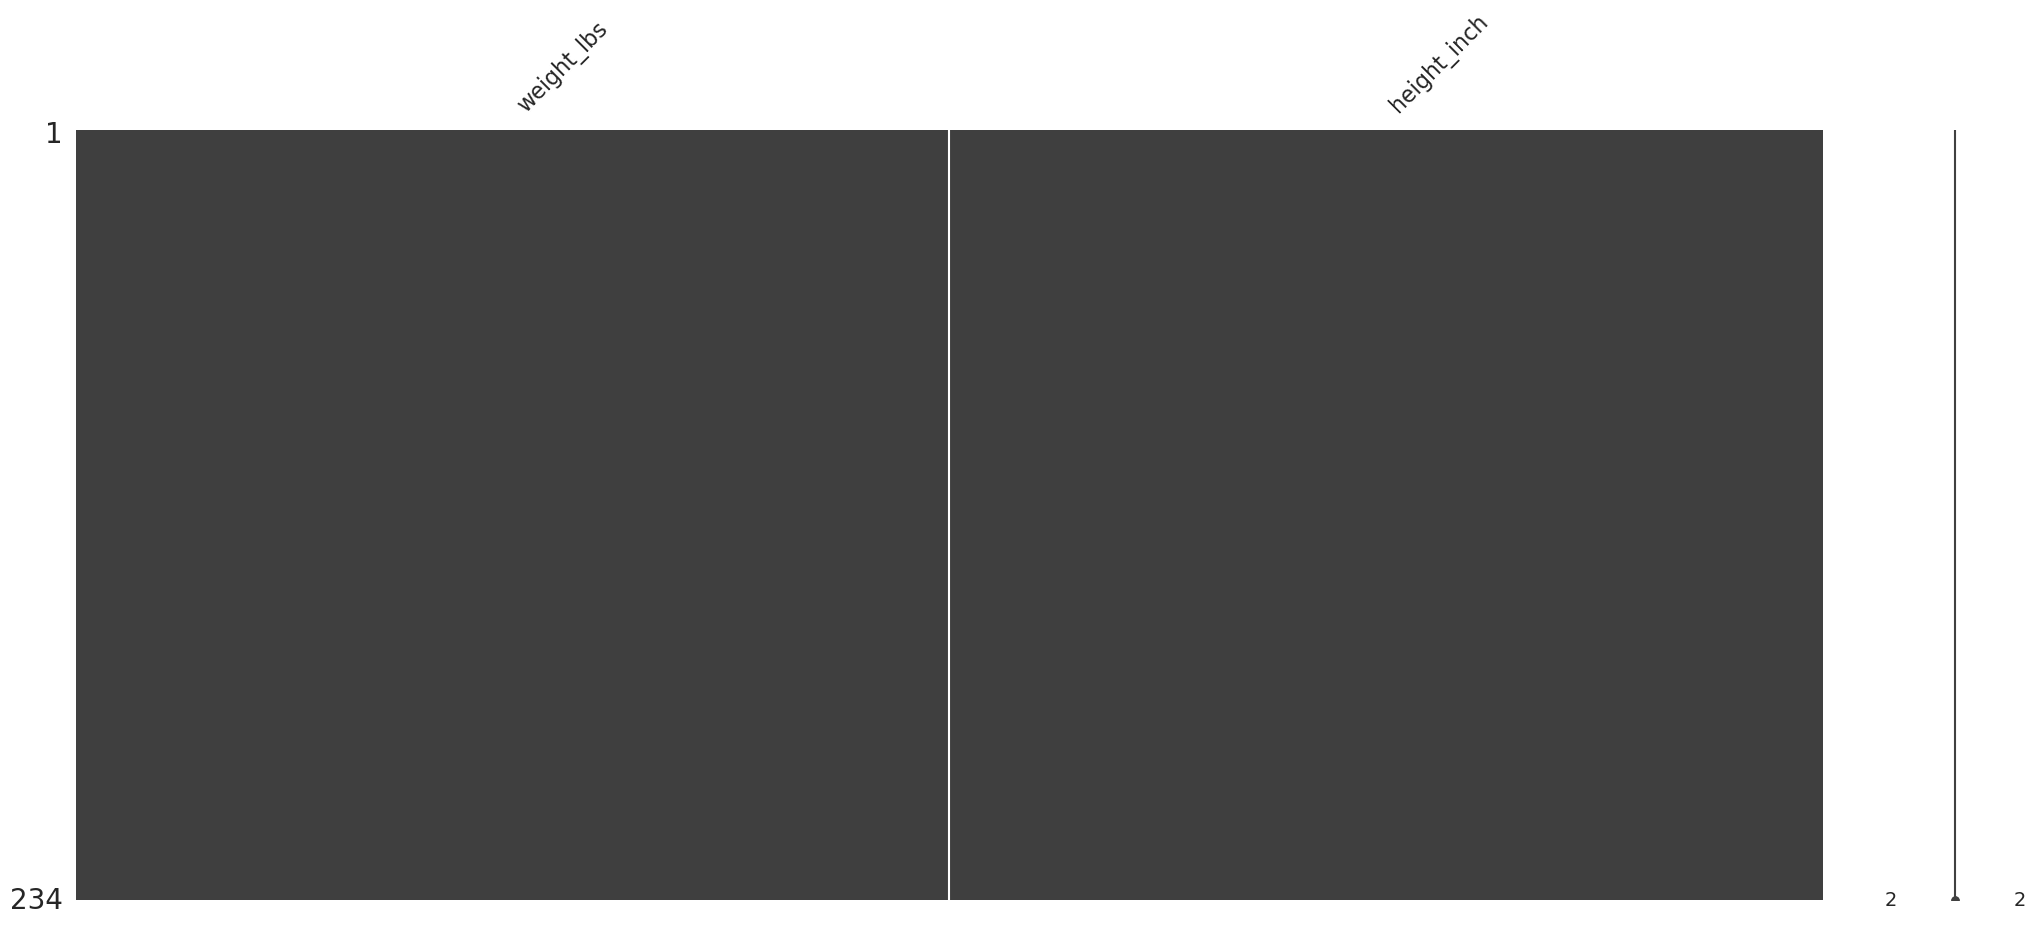

In [29]:
(
    riskfactors_df.dropna(
        subset = ['weight_lbs','height_inch'],
        how = 'any'
    )
    .select_columns(['weight_lbs','height_inch'])
    .pipe(
        missingno.matrix
    )
)

Graficamos algo especial, porque nos dice que no nos faltan nada de datos. Es decir toda la columna esta completa y la gráfica esta coloreada completamente.

Esto es lo que queremos encontrar cuando eliminamos con **listwise deletion de tipo `any`**

/home/dens/miniforge3/envs/deteccion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


<AxesSubplot:>

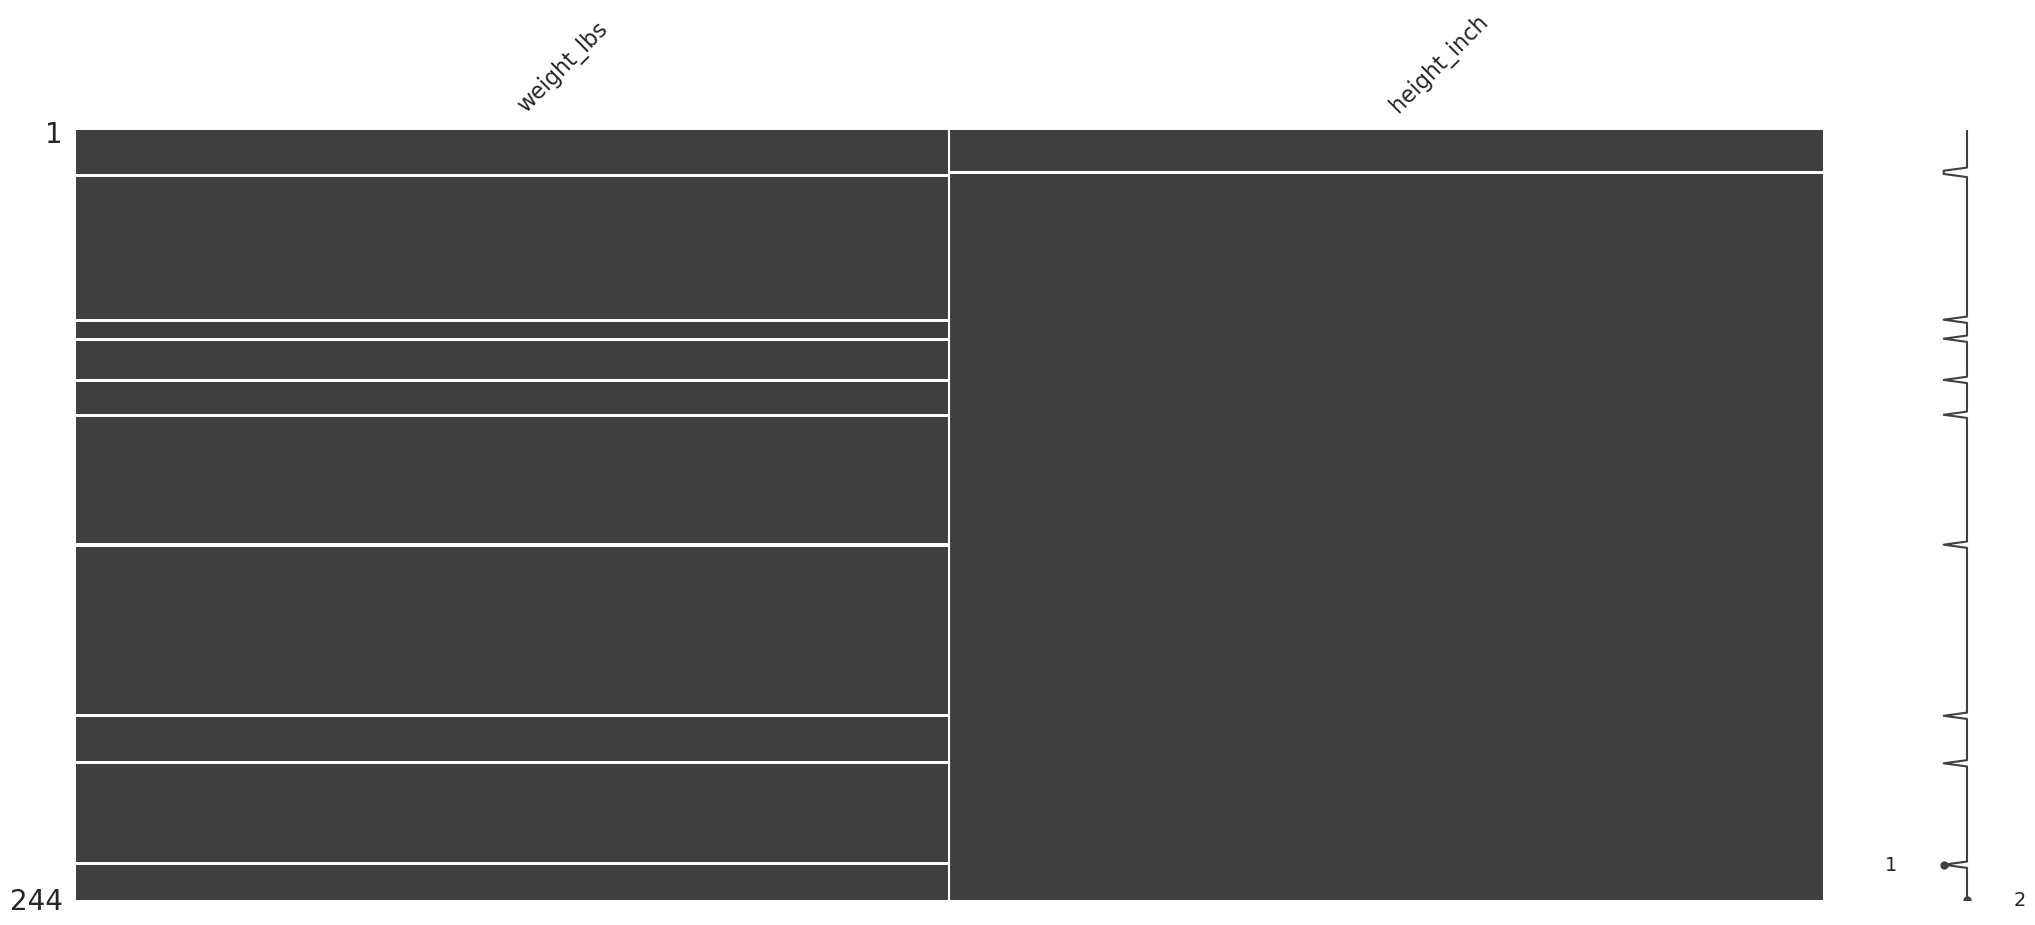

In [30]:
(
    riskfactors_df.dropna(
        subset = ['weight_lbs','height_inch'],
        how = 'all'
    )
    .select_columns(['weight_lbs','height_inch'])
    .pipe(
        missingno.matrix
    )
)

Esto es lo que queremos encontrar cuando eliminamos con **listwise deletion de tipo `all`**

En el cual vemos que para una variable tenemos varios **valores faltantes** y en el otro puede ser que también, pero no vamos a ver que coincidan en la misma observación o fila como en el caso que viene.

#### Valores faltantes que coinciden

/home/dens/miniforge3/envs/deteccion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


<AxesSubplot:>

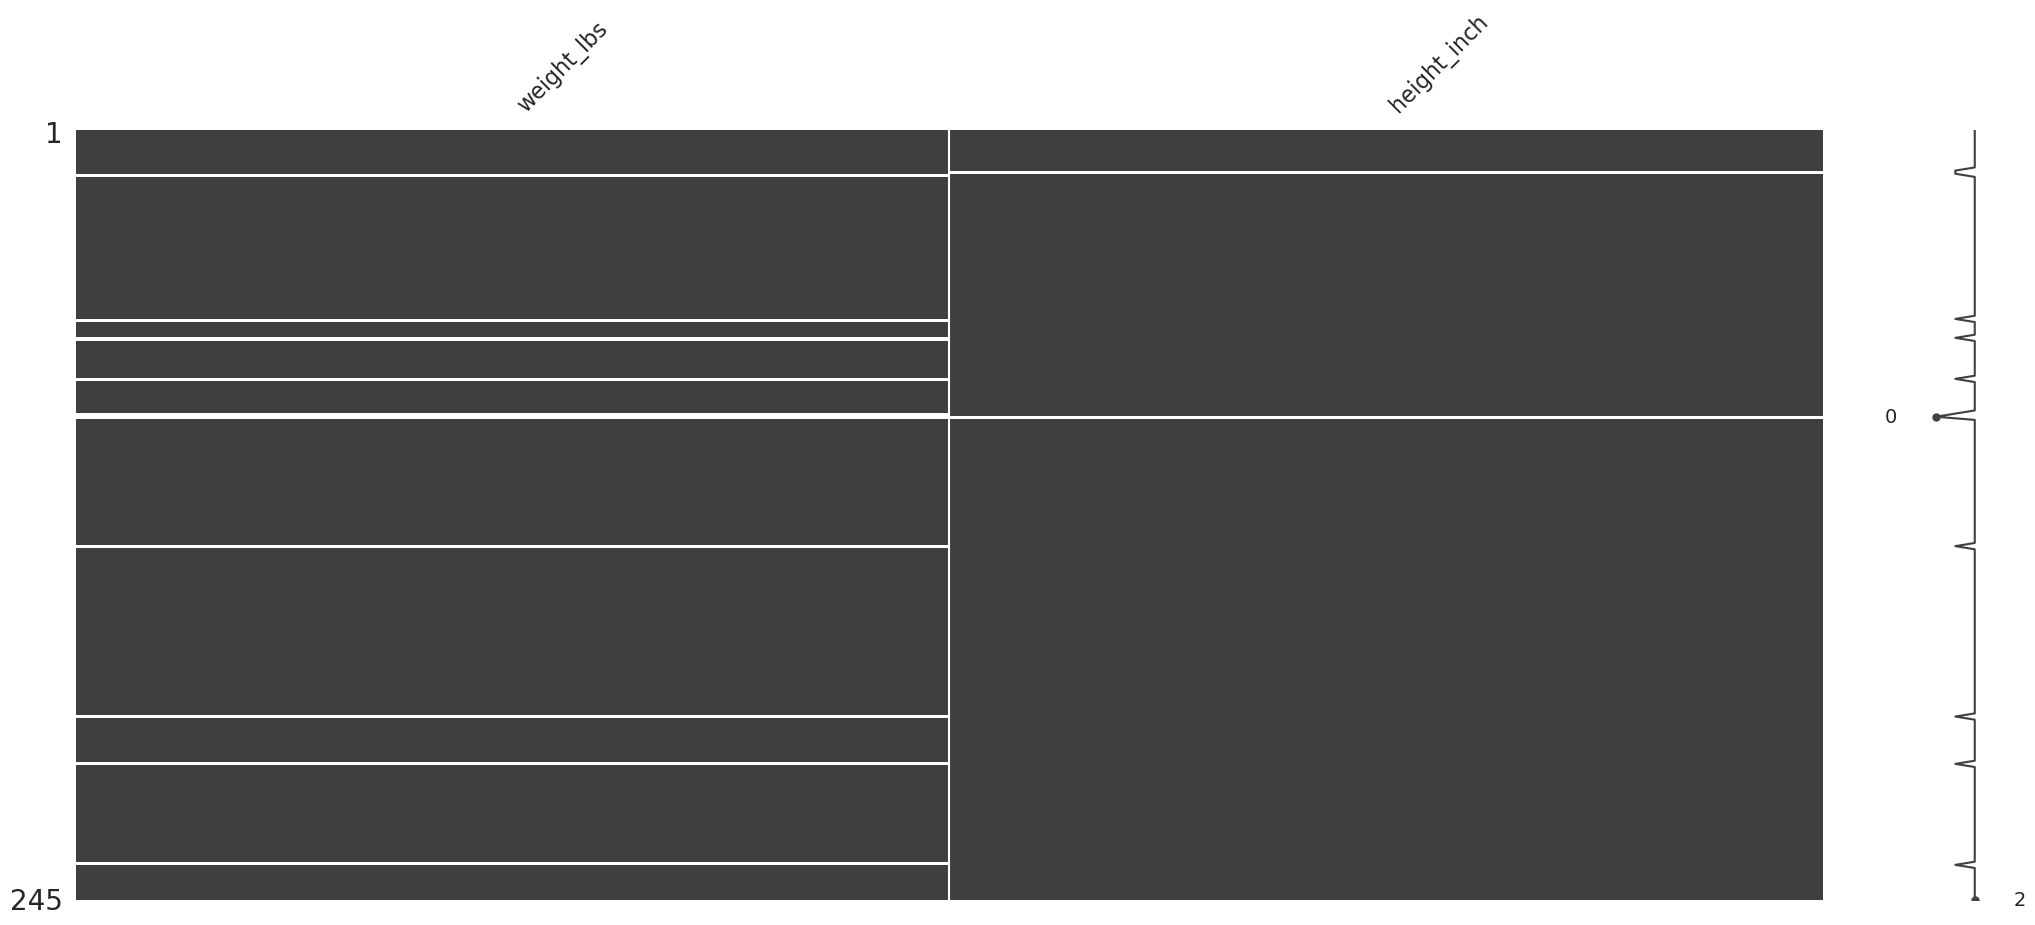

In [31]:
(
    riskfactors_df
    .select_columns(['weight_lbs','height_inch'])
    .pipe(
        missingno.matrix
    )
)

Cómo se puede observar en la gráfica anterior hay una zona donde coinciden los valores faltantes en ambas variables:

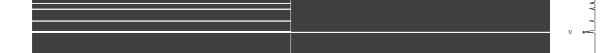

Por lo que se puede ver una linea blanca que atraviesa las 2 gráficas.

### En resumen
Así podemos ver como lucen mis variables después de haber trabajado con valores faltantes.

Aprendimos 2 tipos de eliminación:
1. Pairwise: Se trata de ignorar valores faltantes cuando estemos realizando un calculo, como:
   - Suma
   - Media
   - Conteo
2. Listwise: Si tenemos alguna observación con valor faltante en aquellas posiciones que los tengamos, simplemente se van a eliminar del análisis; quedándome con casos completos (es decir filas con valores completos para esa variable), también aprendimos a realizarlo con varias variables de interés en diferentes forma; para no tener valores faltantes o solo para tener en solo una variable pero nunca que coincidan. 